# Notebook initialization

## Selecting best GPU

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = 0#min(zip(ids, ratios), key=lambda x: x[1])[0]

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 0


##  Global variables

In [2]:
# IPython extension to reload modules before executing user code.
# 'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

root_path = '/linux/mnovak/Documents/Thesis/Code'

simulation_id = 7
weights_id = 6

weights_path = lambda name: root_path + '/weights/{}/{}/'.format(weights_id, name)
figures_path = lambda name: 'figures/{}/{}/'.format(simulation_id, name)

## Seed initialization (for reproductible results)

In [3]:
# Setting the seed for NumPy generated random numbers
import numpy as np
np.random.seed(0)

# Setting the seed for Python random numbers
import random as rn
rn.seed(0)

# Setting the seed for TensorFlow random numbers
import tensorflow as tf
tf.set_random_seed(0)

# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# set_session(tf.Session(config=config))

# Importing weights

In [4]:
import numpy as np
import keras
from keras.callbacks import Callback
from functools import reduce
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy.linalg import norm
import itertools

import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as animation
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
from collections import OrderedDict
import pathlib
import pickle

from math import ceil, floor

Using TensorFlow backend.


In [5]:
import sys
sys.path.insert(0, root_path)

from data_utils import *
from keras_utils import *
from models import VGG16_beta
from layca_optimizers import SGD

In [6]:
num_classes = 10

In [7]:
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [8]:
# Simply loading both the initial and finals weights of our models

models = {  
    'vgg16_sgd_0':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_1':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_2':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    
    'vgg16_wdecay_0':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_1':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_2':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    
    'vgg16_layca_0':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_1':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_2':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)
} 

In [9]:
for name, model in models.items():
    pathlib.Path(figures_path(name)).mkdir(parents=True, exist_ok=True)

In [22]:
%matplotlib notebook
import math

class Accumulate(Callback):
    def __init__(self, name, batch_size, layer):
        super(Accumulate, self).__init__()
        self.W_i = list()
        self.W_f = list()
#         self.dW = list()

        self.W = list()
        self.layer = layer
        self.batch_size = batch_size
        self.name = name
        
        self.n_kernels = get_layer_weights(self.layer).shape[-1]
        self.angular_deviations = np.zeros((1, self.n_kernels))
        

    def on_batch_begin(self, batch, logs=None):
        self.W_i = get_layer_weights(self.layer)
        self.W.append(self.W_i)
    
    def on_batch_end(self, batch, logs=None):
        self.W_f = get_layer_weights(self.layer)
#         print(self.W_f.shape)
        
        if len(self.W_i.shape) == 2:
            pass
        else:
            assert len(self.W_i.shape) == 4
            n_kernels = self.W_i.shape[-1]
            weights_size = self.W_i.shape[0]*self.W_i.shape[1]*self.W_i.shape[2]
            
            for kernel_idx in range(n_kernels):
                self.angular_deviations[0, kernel_idx] += cosine_distance(self.W_i[:,:,:,kernel_idx].flatten(), 
                                                                       self.W_f[:,:,:,kernel_idx].flatten())
#                 dw = np.absolute(self.W_f[:,:,:,kernel_idx] - self.W_i[:,:,:,kernel_idx]).flatten()
#                 self.dW.append(dw)
                     

In [23]:
def train(model_name, layer, lr, epoch, callbacks):
    model = models[model_name]
    model.load_weights(weights_path(model_name) + 'byepoch/weights-{:02d}.hdf5'.format(epoch)) 

    with open(weights_path(model_name) + 'parameters.pickle', 'rb') as handle:
        parameters = pickle.load(handle)
    
    #ISSUE : lr must be the lr at epoch and not the starting lr
    sgd = SGD(lr, momentum=parameters['momentum'], nesterov=True, layca=('layca' in model_name))
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    model.fit(x=x_train, 
              y=y_train,
              validation_split=parameters['validation_split'],
              batch_size=parameters['batch_size'], 
              epochs=1, 
              verbose=1, 
              callbacks=callbacks,
             )

In [29]:
model_name = 'vgg16_layca_2'
model = models[model_name]
layer = get_kernel_layer(model)[-4] 

In [10]:
names = ['vgg16_sgd_2', 'vgg16_wdecay_2', 'vgg16_layca_2']

n_epochs = defaultdict()

for name in names:
    with open(weights_path(name) + 'lrates.pickle', 'rb') as handle:
        n_epochs[name] = len(pickle.load(handle))   
        
print(n_epochs)

defaultdict(None, {'vgg16_wdecay_2': 21, 'vgg16_layca_2': 25, 'vgg16_sgd_2': 20})


In [19]:
Ws = list()

for i, name in enumerate(names):
    print(name)
    model = models[name]
    
    Ws.append(defaultdict(list))
    
    model.load_weights(weights_path(name) + 'initial/weights-initial.hdf5') 
    
    Ws[i][0] = [x.flatten() for x in get_kernel_weights(model)]
    
    for epoch in range(1, n_epochs[name]+1):
        print(epoch)
        
        model.load_weights(weights_path(name) + 'byepoch/weights-{:02d}.hdf5'.format(epoch)) 
    
        Ws[i][epoch] = [x.flatten() for x in get_kernel_weights(model)]
        
        

vgg16_sgd_2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
vgg16_wdecay_2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
vgg16_layca_2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [20]:
Ws[0][0][0].shape

(1728,)

In [74]:
list(range(lo, len(layers[lo:up]) * 2, 2))

[7, 9, 11, 13, 15]

<IPython.core.display.Javascript object>


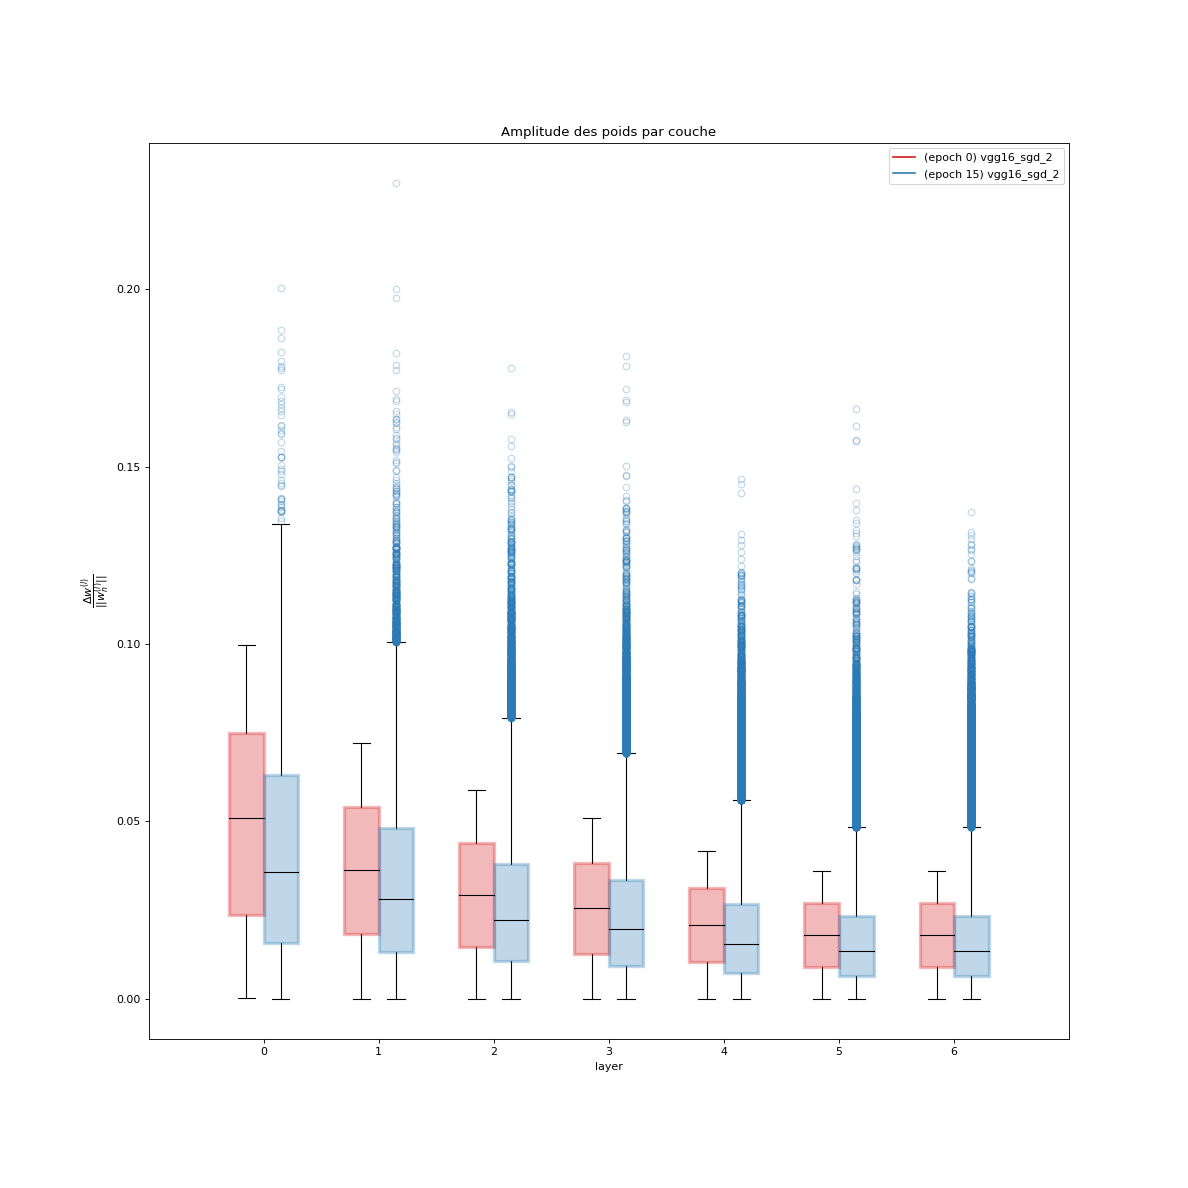

In [94]:
%matplotlib notebook

layers = np.arange(15)

lo=0
up=7

def set_box_color(ax, bp, color):
#     for element in ['boxes', 'whiskers', 'fliers', 'caps']:
#         plt.setp(bp[element], color='#000000')

    plt.setp(bp['fliers'], markeredgecolor=color, alpha=0.3)
    plt.setp(bp['medians'], color='#000000')
    plt.setp(bp['boxes'], color='#000000', linewidth=3)
    
    for patch in bp['boxes']:
        patch.set(color=color, alpha=0.3)       
    
colors = ['#D7191C', '#2C7BB6', '#31a354'] 
    
fig, ax = plt.subplots(figsize=(15, 15))

name = 'vgg16_sgd_2'
W = Ws[2]

epoch1 = 0
epoch2 = 15

w1 = W[epoch1]
w2 = W[epoch2]

bp1 = plt.boxplot(np.abs(w1[lo:up]), positions=np.arange(len(w1[lo:up]))*2.0 - 0.3, widths=0.6, patch_artist=True)
bp2 = plt.boxplot(np.abs(w2[lo:up]), positions=np.arange(len(w2[lo:up]))*2.0 + 0.3, widths=0.6, patch_artist=True)
set_box_color(ax, bp1, colors[0]) # colors are from http://colorbrewer2.org/
set_box_color(ax, bp2, colors[1])

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c=colors[0], label='(epoch {}) '.format(epoch1) + name)
plt.plot([], c=colors[1], label='(epoch {}) '.format(epoch2) + name)
plt.legend()

plt.title('Amplitude des poids par couche')
plt.ylabel(r'$\dfrac{\Delta w^{(l)}}{||w^{(l)}_n||}$')
plt.xlabel('layer')
plt.xticks(range(0, len(layers[lo:up]) * 2, 2), layers[lo:up])
plt.xlim(-2, len(layers[lo:up])*2)

plt.show()

fig.savefig('layca_amp.png', dpi=100)

In [ ]:
epoch_number = 10#10 0.0010000000474974513

with open(weights_path(model_name) + 'parameters.pickle', 'rb') as handle:
    parameters = pickle.load(handle)

callbacks = [Accumulate(model_name, parameters['batch_size'], layer)]
train(model_name, layer=layer, lr=0.05000000074505806, epoch=1, callbacks=callbacks)

In [30]:
# acc = callbacks[0]

# # min_kernel = np.argmin(acc.angular_deviations)
# # max_kernel = np.argmax(acc.angular_deviations)


# n_steps = len(acc.W)

# def normalized_weights(step):
#     W_step = acc.W[step].reshape((acc.W[step].shape[0]*acc.W[step].shape[1]*acc.W[step].shape[2],
#                                   acc.W[step].shape[3]))

#     W_normalized = (W_step - np.mean(W_step, axis=0)) / np.std(W_step, axis=0)
    
#     # aggregate the distribution of all kernels of the layer
#     W_sum = np.sum(W_normalized, axis=1)
    
#     return np.abs((W_sum - np.mean(W_sum)) / np.std(W_sum))

# for step in range(n_steps):
#     weights = normalized_weights(step)
#     Y[:, step] = number_in_regions(weights, p25, p50, p75)
    
import os

path, dirs, files = next(os.walk(weights_path(model_name) + 'byepoch'))
n_epochs = len(files)
print(n_epochs)
    
def normalized_weights(epoch):
    model.load_weights(weights_path(model_name) + 'byepoch/weights-{:02d}.hdf5'.format(epoch+1)) 
    
    W_epoch = get_layer_weights(layer)
    
    W_reshaped = W_epoch.reshape((W_epoch.shape[0]*W_epoch.shape[1]*W_epoch.shape[2],
                                  W_epoch.shape[3]))

    W_normalized = (W_reshaped - np.mean(W_reshaped, axis=0)) / np.std(W_reshaped, axis=0)
    
    # aggregate the distribution of all kernels of the layer
    W_sum = np.sum(W_normalized, axis=1)
    
    return np.abs((W_sum - np.mean(W_sum)) / np.std(W_sum))


# initial_weights = normalized_weights(0)
# p25 = np.percentile(initial_weights, 25)
# p50 = np.percentile(initial_weights, 50)
# p75 = np.percentile(initial_weights, 75)

def number_in_regions(arr, p25, p50, p75):    
    region1 = (arr < p25).sum()  
    region2 = (np.logical_and(arr >= p25, arr <= p50)).sum()  
    region3 = (np.logical_and(arr >= p50, arr <= p75)).sum()    
    region4 = (arr > p75).sum()  
        
    return [region1, region2, region3, region4]

Y = np.zeros((4, n_epochs-1))

for epoch in range(n_epochs-1):
    print(epoch)
    
    initial_weights = normalized_weights(epoch)
    p25 = np.percentile(initial_weights, 25)
    p50 = np.percentile(initial_weights, 50)
    p75 = np.percentile(initial_weights, 75)
    
    initial_number = (initial_weights < p25).sum()
    
    final_weights = normalized_weights(epoch+1)
    Y[:, epoch] = number_in_regions(final_weights, p25, p50, p75) - initial_number

50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.1

for region, (color, label) in enumerate(zip(['#EED26A', '#EB8453', '#CB5539', '#723330'], 
                                            [r'$w < p25$', r'$p25 < w < p50$', r'$p50 < w < p75$', r'$w > p75$'])):
#     ax.plot(np.arange(n_epochs-1), Y[region, :], linestyle='--', marker='o', markersize=3, color=color, label=label)
    ax.bar(np.arange(n_epochs-1) + region*bar_width, Y[region, :], bar_width, color=color, label=label)

ax.set_xticks(np.arange(n_epochs-1) + 1.5*bar_width)
ax.set_xticklabels(('{}-{}'.format(e1, e2) for e1, e2 in zip(range(1, n_epochs), range(2, n_epochs+1))))
ax.legend()


# n_bins = 100
# def plot_histogram(step):
#     weights = normalized_weights(step)
#     n, bins, patches = ax.hist(weights, n_bins, normed=1, facecolor='green', alpha=0.5)
# #     y = mlab.normpdf(bins, np.mean(weights), np.std(weights))
# #     ax.plot(bins, y, 'r--')

# plot_histogram(0)

# axamp = plt.axes([0.25, .03, 0.50, 0.02])
# # Slider
# samp = Slider(axamp, 'step number', 1, n_steps, valinit=1)

# def update(val):
#     # amp is the current value of the slider
#     step = math.ceil(samp.val)-1
# #             # update curve
# #             l.set_ydata(self.W[step][:,:,:, max_kernel].flatten())
# #             # redraw canvas while idle
# #             fig.canvas.draw_idle()

#     ax.cla()
#     plot_histogram(step)

# # call update function on slider value change
# samp.on_changed(update)

plt.show() 

<IPython.core.display.Javascript object>


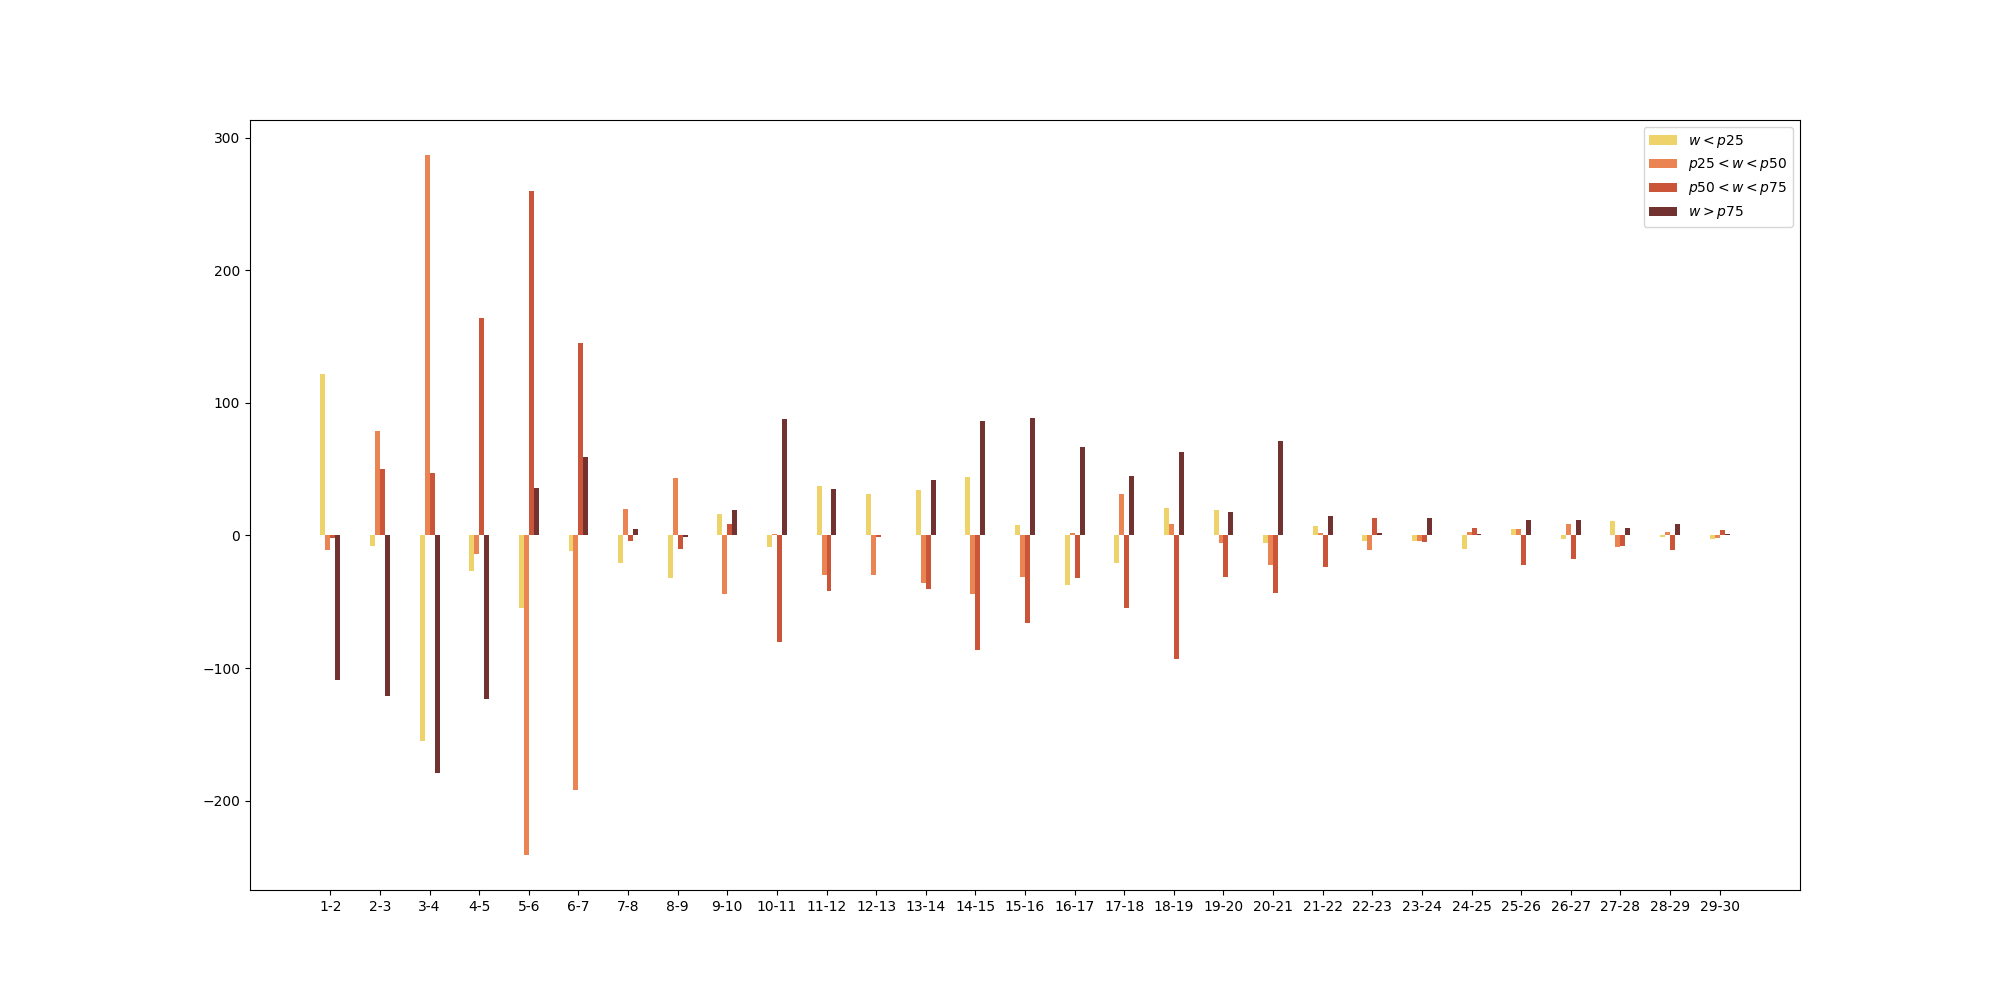

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.1

for region, (color, label) in enumerate(zip(['#EED26A', '#EB8453', '#CB5539', '#723330'], 
                                            [r'$w < p25$', r'$p25 < w < p50$', r'$p50 < w < p75$', r'$w > p75$'])):
#     ax.plot(np.arange(n_epochs-1), Y[region, :], linestyle='--', marker='o', markersize=3, color=color, label=label)
    ax.bar(np.arange(n_epochs-1) + region*bar_width, Y[region, :], bar_width, color=color, label=label)

ax.set_xticks(np.arange(n_epochs-1) + 1.5*bar_width)
ax.set_xticklabels(('{}-{}'.format(e1, e2) for e1, e2 in zip(range(1, n_epochs), range(2, n_epochs+1))))
ax.legend()


# n_bins = 100
# def plot_histogram(step):
#     weights = normalized_weights(step)
#     n, bins, patches = ax.hist(weights, n_bins, normed=1, facecolor='green', alpha=0.5)
# #     y = mlab.normpdf(bins, np.mean(weights), np.std(weights))
# #     ax.plot(bins, y, 'r--')

# plot_histogram(0)

# axamp = plt.axes([0.25, .03, 0.50, 0.02])
# # Slider
# samp = Slider(axamp, 'step number', 1, n_steps, valinit=1)

# def update(val):
#     # amp is the current value of the slider
#     step = math.ceil(samp.val)-1
# #             # update curve
# #             l.set_ydata(self.W[step][:,:,:, max_kernel].flatten())
# #             # redraw canvas while idle
# #             fig.canvas.draw_idle()

#     ax.cla()
#     plot_histogram(step)

# # call update function on slider value change
# samp.on_changed(update)

plt.show() 

In [ ]:
#mettre les distributions et comparer avec le pruning
